# Comparing existing and new links

Dominika Tkaczyk

13.10.2018

In this analysis I examine how the links existing in the live system compare to the links currently returned by both STQ and SBM algorithms.

For the comparison of the two algorithms on automatically generated reference strings, see [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/comparison.ipynb).

## TL;DR

  * I examined 1000 random reference strings from the live system. For each one I keep:
    * original link (currently in the system)
    * STQ link (the link returned by STQ form)
    * SBM link (the link returned by SBM algorithm)
  * 46% of reference strings are currently unmatched in the system:
    * of those unmatched, in 32% cases STQ returned DOI
    * of those unmatched, in 30% cases STQ DOI is the same as SBM (almost every DOI returned by STQ was "confirmed" by SBM)
    * according to the estimations, when STQ did not give any answer, SA was correct in 16% cases
  * The remaining 54% of reference strings are currently matched in the system:
    * of those matched, in 89% cases all three links are the same; this confirms high agreement of STQ and SBM
    * of those matched, in 6% of the references STQ link is missing, but the original link is the same as SBM
    * of those matched, in 4% of the cases SBM link is incorrect; the most common causes are:
      * a short reference string without the title
      * choosing a document closely related to the real target, such that usually contains all the real target's metadata, such as a review or a chapter instead of the book
  * The highest level of agreement between the links is obtained for the thresholds:
    * simple threshold 67: in 64.6% of the cases all links agree and in 82.5% of the cases SBM link is equal to either original or new STQ link
    * normalized threshold 0.46: in 67.5% of the cases all links agree and in 85.2% of the cases SBM link is equal to either original or new STQ link

## Methodology

The following procedure was used to gather the data for this experiment:
1. A random sample of 5000 items was extracted from the system.
2. I iterated over all references in the sampled items, and extracted all 6289 unstructured references (reference strings).
3. I sampled 1000 unstructured references from them and ran both STQ and SBM algorithms on them.
4. I examined the differences between the links.

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from utils.utils import read_json, save_json

DATA_DIR = '../data/existing_links/'

Let's read the data:

In [2]:
data = read_json(DATA_DIR + 'sample_1000_reasons.json')
orig_link = 'original_link'
stq_link = 'current_STQ_link'
sbm_link = 'search_API_link'
print(json.dumps(data[0], indent=4))

{
    "source_DOI": "10.1186/s12879-018-3375-3",
    "ref_string": "Rocha LA, Ferreira de Almeida EBL, Gontijo Filho PP. Changes in hands microbiota associated with skin damage because of hand hygiene procedures on the health care workers. Am J Infect Control. 2009;37(2):155\u20139.",
    "original_link": "10.1016/j.ajic.2008.04.251",
    "current_STQ_link": "10.1016/j.ajic.2008.04.251",
    "search_API_link": "10.1016/j.ajic.2008.04.251",
    "search_API_score": 108.036255,
    "reason": "all links agree"
}


For each reference, I keep the following information:
  * source DOI
  * reference string
  * original link: link currently existing in the system, can be null
  * current STQ link: link obtained from STQ, can be null
  * search API link: link obtained from SBM, can be null
  * search API score: relevance score from SBM

### Null original link

The first category we will explore are references currently not matched to any target document in the system. How many references don't have the original link?

In [3]:
data_orig_null = [d for d in data if d[orig_link] is None]
print('Null original link: {}'.format(len(data_orig_null)))

Null original link: 458


45.8% of reference strings in our sample are not linked to anything. In how many cases we have a new STQ link?

In [4]:
data_orig_null_stq_exists = [d for d in data_orig_null if d[stq_link] is not None]
print('Null original link, STQ link exists: {}'.format(len(data_orig_null_stq_exists)))

Null original link, STQ link exists: 146


In 32% of references with null original link we have the new STQ link. And how many of those have the same SBM link?

In [5]:
data_orig_null_sbm_stq_equal = [d for d in data_orig_null if d[stq_link] is not None and d[stq_link] == d[sbm_link]]
print('Null original link; STQ and SBM agree: {}'.format(len(data_orig_null_sbm_stq_equal)))

Null original link; STQ and SBM agree: 139


It seems there is a high agreement between STQ and SBM, almost all new STQ links were "confirmed" by SBM.

We are left with 319 cases, in which the original link is null and STQ and SBM links differ. I manually inspected a sample of them and provided an explanation of what happened. This function will show the distribution of those explanations ("comments"):

In [6]:
def summarize_comments(data):
    comments = [d['reason'] for d in data]
    comments = list(set([(r, comments.count(r)) for r in comments]))
    comments.sort(key=lambda x: x[1], reverse=True) 
    return comments 

The distribution of the explanations of the cases where original link is null and SBM and STQ links disagree:

In [7]:
data_orig_null_sbm_stq_disagree = [d for d in data_orig_null if d[stq_link] != d[sbm_link]]
summarize_comments(data_orig_null_sbm_stq_disagree)

[('original link null; STQ link null; SBM link not inspected', 185),
 ('original link null; STQ link null; SBM link incorrect', 104),
 ('original link null; STQ link null; SBM link correct', 20),
 ('original link null; STQ link null; SBM links to a review', 3),
 ('original link null; STQ and SBM disagree; same landing page', 2),
 ('original link null; STQ and SBM disagree; SBM links to a chapter', 1),
 ('original link null; STQ and SBM disagree; SBM correct', 1),
 ('original link null; STQ and SBM disagree, SBM link broken', 1),
 ('original link null; STQ and SBM disagree; SBM link incorrect', 1),
 ('original link null; STQ and SBM disagree; same metadata', 1)]

We have the following cases:
  * 185: only SBM link present; not inspected manually
  * 107: only SBM link present and incorrect 
  * 20: only SBM present and correct
  * 3: STQ and SBM links disagree, but the either the landing pages or the document metadata are the same
  * 4: other cases

### All links agree

How many cases we have, in which all three links agree?

In [8]:
data_all_agree = [d for d in data
                  if d[orig_link] is not None and d[orig_link] == d[stq_link] and d[sbm_link] == d[stq_link]]
print('All links agree: {}'.format(len(data_all_agree)))

All links agree: 481


Almost half of all the cases, and 89% of the cases with not null original link. This also confirms high agreement between STQ and SBM.

### Original link is different

In how many cases SBM link is the same as STQ link, but original link is not null and different?

In [9]:
data_diff_orig = [d for d in data
                  if d[orig_link] is not None and d[orig_link] != d[stq_link] and d[sbm_link] == d[stq_link]]
print('Original link is different : {}'.format(len(data_diff_orig)))
summarize_comments(data_diff_orig)

Original link is different : 2


[('original link incorrect', 1), ('different version of the paper', 1)]

Only 2 references:
  * in one case the DOIs link to two different versions of the same paper
  * in the second case the original link is incorrect
  
### STQ link is different
  
Now let's see the cases, where original and SBM links agree and STQ is different:

In [10]:
data_diff_stq = [d for d in data
                 if d[orig_link] is not None and d[orig_link] != d[stq_link] and d[sbm_link] == d[orig_link]]
print('STQ link is different : {}'.format(len(data_diff_stq)))
summarize_comments(data_diff_stq)

STQ link is different : 32


[('STQ link missing', 32)]

In all cases STQ link is simply missing.

### SBM link is different

How many cases we have, where SBM link is different from the other two?

In [11]:
data_diff_sbt = [d for d in data
                if d[orig_link] is not None and d[orig_link] == d[stq_link] and d[sbm_link] != d[orig_link]]
print('SBT link is different : {}'.format(len(data_diff_sbt)))
summarize_comments(data_diff_sbt)

SBT link is different : 24


[('SBM link incorrect', 14),
 ('same document (metadata)', 3),
 ('SBM links to a chapter', 2),
 ('same document (landing page)', 2),
 ('original link incorrect', 1),
 ('SBM links to a correction', 1),
 ('SBM links to one paper in conference proceedings', 1)]

Out of 24 cases:
  * in 14 cases SBM link is incorrect (11 of those are strings not containing the title of the reference)
  * in 5 the linked documents appear to be the same
  * in 4 cases SBM links to a document related to the correct one, such as a chapter or a correction
  * in 1 case the original link is incorrect

### All three links are different

In [12]:
data_diff_all = [d for d in data
                 if d[orig_link] is not None and d[orig_link] != d[stq_link]
                 and d[sbm_link] != d[orig_link] and d[stq_link] != d[sbm_link]]
print('All links different : {}'.format(len(data_diff_all)))
summarize_comments(data_diff_all)

All links different : 3


[('STQ link missing; both link to a different chapter', 2),
 ('STQ link missing; SBM link incorrect', 1)]

In all three cases STQ link is missing and SBT link is incorrect.

### Overall distribution

Finally, let's see the overall distribution of all 1000 cases:

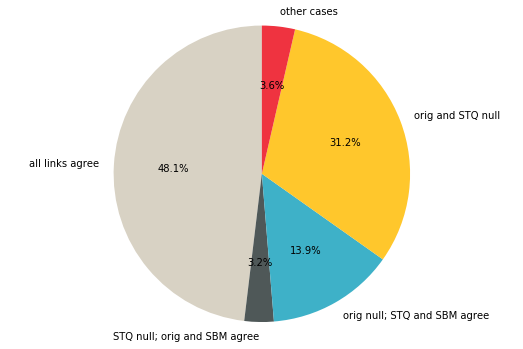

In [13]:
labels = 'all links agree', 'STQ null; orig and SBM agree', 'orig null; STQ and SBM agree', \
         'orig and STQ null', 'other cases'
sizes = [481, 32, 139, 312, 36]

fig, ax = plt.subplots(figsize=(9,6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
       colors=['#d8d2c4', '#4f5858', '#3eb1c8', '#ffc72c', '#ef3340'])
ax.axis('equal')

plt.show()

### The rate of agreement vs. relevance threshold

Let's also see how the relevance threshold affects the agreement between the links.

These functions modify the dataset according to the threshold:

In [14]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item['search_API_score'] < threshold:
            item[sbm_link] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item['search_API_score']/len(item['ref_string']) < threshold:
            item[sbm_link] = None
    return dataset

get_category classifies an item from the dataset into one of the categories:
  * *SBM = STQ = orig* (all links agree)
  * *SBM = STQ =/= orig* (original link is different)
  * *SBM = orig =/= STQ* (new STQ link is different)
  * *SBM =/= STQ = orig* (SBM link is different)
  * *other*

Note that links are different if they point to different DOIs or only one of them is null.

In [15]:
def get_category(item):
    if (item['reason'] == 'all links agree' and item[sbm_link] is not None) or \
        (item[sbm_link] == item[orig_link] and item[sbm_link] == item[stq_link]):
        return 'SBM = STQ = orig'
    if ('STQ correct' in item['reason'] and 'SBM correct' in item['reason'] and item[sbm_link] is not None) \
        or (item[sbm_link] != item[orig_link] and item[sbm_link] == item[stq_link]):
        return 'SBM = STQ =/= orig'
    if ('orig correct' in item['reason'] and 'SBM correct' in item['reason'] and item[sbm_link] is not None) \
        or (item[sbm_link] == item[orig_link] and item[sbm_link] != item[stq_link]):
        return 'SBM = orig =/= STQ'
    if ('STQ correct' in item['reason'] and 'orig correct' in item['reason']) \
        or (item[sbm_link] != item[orig_link] and item[orig_link] == item[stq_link]):
        return 'SBM =/= STQ = orig'
    return 'other'

What happens with the categories in the dataset as we vary the simple threshold?

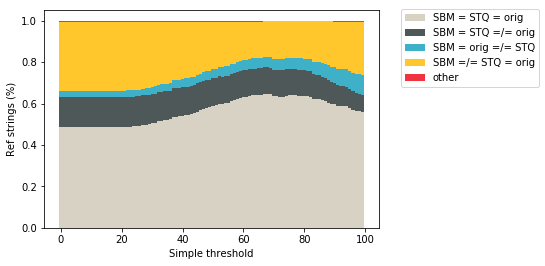

In [16]:
data = read_json(DATA_DIR + 'sample_1000.json')
data_categories = [[get_category(d) for d in modify_simple_threshold(data, t)] for t in np.arange(0, 100, 1)]
categories = ['SBM = STQ = orig', 'SBM = STQ =/= orig', 'SBM = orig =/= STQ', 'SBM =/= STQ = orig', 'other']
categories_counts = [[d.count(cat)/1000 for d in data_categories] for cat in categories]

ind = np.arange(0, 100, 1)
p1 = plt.bar(ind, categories_counts[0], width=1, color='#d8d2c4')
p2 = plt.bar(ind, categories_counts[1], width=1, bottom=categories_counts[0], color='#4f5858')
p3 = plt.bar(ind, categories_counts[2], width=1,
             bottom=[c1+c2 for c1, c2 in zip(categories_counts[0],categories_counts[1])], color='#3eb1c8')
p4 = plt.bar(ind, categories_counts[3], width=1,
             bottom=[c1+c2+c3 for c1, c2, c3 in zip(categories_counts[0],categories_counts[1],categories_counts[2])],
             color='#ffc72c')
p5 = plt.bar(ind, categories_counts[4], width=1,
             bottom=[c1+c2+c3+c4 for c1, c2, c3, c4 in zip(categories_counts[0],categories_counts[1],
                                                           categories_counts[2],categories_counts[3])],
             color='#ef3340')

plt.xlabel('Simple threshold')
plt.ylabel('Ref strings (%)')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), categories, bbox_to_anchor=(1.05, 1.03))

plt.show()

Based on this, the best simple threshold is 67. For this threshold, all links agree in 646 cases and in additional 179 cases SBM link is equal to either original or new STQ link. In total, SBM link agrees with original or new STQ link in 82.5% cases.

What happens with the categories in the dataset as we vary the normalized threshold?

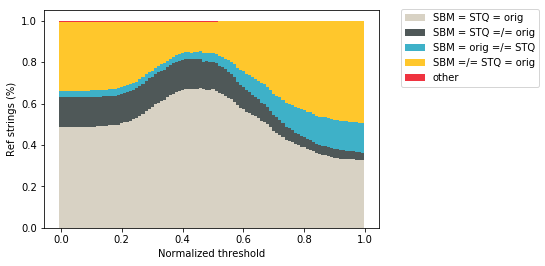

In [17]:
data = read_json(DATA_DIR + 'sample_1000.json')
data_categories = [[get_category(d) for d in modify_norm_threshold(data, t)] for t in np.arange(0.0, 1.0, 0.01)]
categories_counts = [[d.count(cat)/1000 for d in data_categories] for cat in categories]

ind = np.arange(0.0, 1.0, 0.01)
p1 = plt.bar(ind, categories_counts[0], width=0.01, color='#d8d2c4')
p2 = plt.bar(ind, categories_counts[1], width=0.01, bottom=categories_counts[0], color='#4f5858')
p3 = plt.bar(ind, categories_counts[2], width=0.01,
             bottom=[c1+c2 for c1, c2 in zip(categories_counts[0],categories_counts[1])], color='#3eb1c8')
p4 = plt.bar(ind, categories_counts[3], width=0.01,
             bottom=[c1+c2+c3 for c1, c2, c3 in zip(categories_counts[0],categories_counts[1],categories_counts[2])],
             color='#ffc72c')
p5 = plt.bar(ind, categories_counts[4], width=0.01,
             bottom=[c1+c2+c3+c4 for c1, c2, c3, c4 in zip(categories_counts[0],categories_counts[1],
                                                           categories_counts[2],categories_counts[3])],
             color='#ef3340')

plt.xlabel('Normalized threshold')
plt.ylabel('Ref strings (%)')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), categories, bbox_to_anchor=(1.05, 1.03))

plt.show()

Based on this, the best normalized threshold is 0.46. For this threshold, all links agree in 675 cases and in additional 177 cases SBM link is equal to either original or new STQ link. In total, SBM link agrees with original or new STQ link in 85.2% of the cases. Note that the agreement for the best normalized threshold is higher than in the case of the simple threshold.

Let's now apply the normalized threshold of 0.46 (the best value) and look more closely at the disagreements between links.

First, let's check those cases where the original link is different than the other two:

In [18]:
data = read_json(DATA_DIR + 'sample_1000.json')
modify_norm_threshold(data, 0.46)
[d.update({'reason': re.sub('SBM [a-z]+', 'SBM null', d['reason'])}) for d in data if d[sbm_link] is None]
[d.update({'reason': re.sub('all links agree', 'orig correct, STQ correct, SBM null', d['reason'])}) for d in data
 if d[sbm_link] is None]
data_orig_different = [d for d in data if get_category(d) == 'SBM = STQ =/= orig']
summarize_comments(data_orig_different)

[('orig null, STQ correct, SBM correct', 133),
 ('STQ null, orig incorrect, SBM null', 3),
 ('STQ null, orig correct, SBM null', 3)]

In most cases the original link is missing. This might be related to new documents appearing in the system and not linked yet by the backlog processing.

The next category is "new STQ link is different than the other two":

In [19]:
data_stq_different = [d for d in data if get_category(d) == 'SBM = orig =/= STQ']
summarize_comments(data_stq_different)

[('STQ null, orig correct, SBM correct', 27),
 ('orig null, STQ correct, SBM null', 9),
 ('STQ null, orig correct, SBM incorrect', 2)]

Not a lot of cases here. The most common is when original and SBM links are correct, and new STQ link is null.

Now let's inspect those cases, where SBM is different from the other two:

In [20]:
data_sbm_different = [d for d in data if get_category(d) == 'SBM =/= STQ = orig']
summarize_comments(data_sbm_different)

[('orig null, STQ null, SBM incorrect', 49),
 ('orig correct, STQ correct, SBM null', 47),
 ('orig null, STQ null, SBM correct', 36),
 ('orig correct, STQ correct, SBM incorrect', 9),
 ('orig incorrect, STQ incorrect, SBM incorrect', 2)]

This is the biggest group. The most common cases are: both original and STQ links are null, and SBM exists (correct or incorrect), and both original and STQ links are correct and SBM is null.

Finally, the "other" category:

In [21]:
data_other = [d for d in data if get_category(d) == 'other']
summarize_comments(data_other)

[('orig null, STQ correct, SBM incorrect', 2),
 ('orig null, STQ incorrect, SBM correct', 1),
 ('orig null, STQ incorrect, SBM incorrect', 1),
 ('orig incorrect, STQ correct, SBM null', 1)]

Only 5 cases in total.

In summary, for the normalized threshold of 0.46 we have the following:
  * all links agree in 675 cases
  * in 200 cases there are some differences and SBM link is correct
  * in 125 cases there are some differences and SBM link is incorrect

### Precision and recall vs. relevance threshold

Finally, let's see how precision and recall of the original and new STQ compare to SBM on out 1000 reference strings. The values reported here are only approximate, because we did not inspect manually all links. We assume that a link returned by both original and SBM, or STQ and SBM, is correct. The cases with differences were inspected manually. If none of the three links is correct, we also assume the target document doesn't exist.

This function will calculate the precision and recall values for all types of links:

In [22]:
def plot_data(dataset):
    sbm_correct = len([d for d in dataset if (d[sbm_link] is not None and d['reason'] == 'all links agree') or
                      (d[sbm_link] is not None and "SBM correct" in d['reason'])]) 
    sbm_exist = len([d for d in dataset if d[sbm_link] is not None])
    orig_correct = len([d for d in dataset if (d[orig_link] is not None and d['reason'] == 'all links agree') or
                   (d[orig_link] is not None and 'orig correct' in d['reason'])])
    orig_exist = len([d for d in dataset if d[orig_link] is not None])
    stq_correct = len([d for d in dataset if (d[stq_link] is not None and d['reason'] == 'all links agree') or
                   (d[stq_link] is not None and 'STQ correct' in d['reason'])])
    stq_exist = len([d for d in dataset if d[stq_link] is not None])
    gt = len([d for d in dataset if d['reason'] == 'all links agree' or ' correct' in d['reason']])
    
    return sbm_correct/sbm_exist, sbm_correct/gt, \
        orig_correct/orig_exist, orig_correct/gt, \
        stq_correct/stq_exist, stq_correct/gt

Let's plot all precisions and recalls vs. STQ's simple threshold (of course the threshold does not affect original and STQ's numbers):

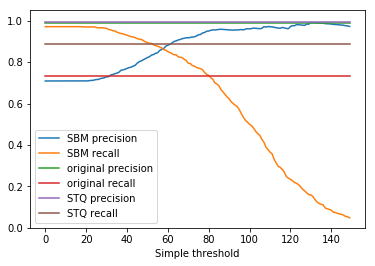

In [23]:
data = read_json(DATA_DIR + 'sample_1000.json')

thresholds = np.arange(0, 150, 1)
results = [plot_data(modify_simple_threshold(data, t)) for t in thresholds]
plt.plot(thresholds, results)
plt.legend(['SBM precision', 'SBM recall', 'original precision', 'original recall',
            'STQ precision', 'STQ recall'])
plt.ylim((0,1.05))
plt.xlabel('Simple threshold')
plt.show()

And the same for the normalized threshold:

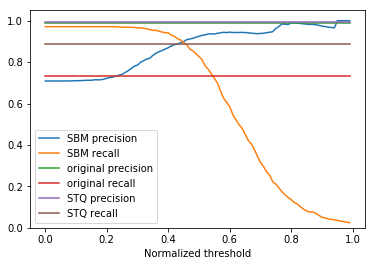

In [24]:
data = read_json(DATA_DIR + 'sample_1000.json')

thresholds = np.arange(0, 1, .01)
results = [plot_data(modify_norm_threshold(data, t)) for t in thresholds]
plt.plot(thresholds, results)
plt.legend(['SBM precision', 'SBM recall', 'original precision', 'original recall',
            'STQ precision', 'STQ recall'])
plt.ylim((0,1.05))
plt.xlabel('Normalized threshold')
plt.show()

Both original and STQ's precisions are very high. We have only a few cases where original or STQ link is incorrect. As a result, matching their precision with SBM algorithm requires very high values of the threshold, and at the same time causes the recall to drop significantly below STQ's recall.